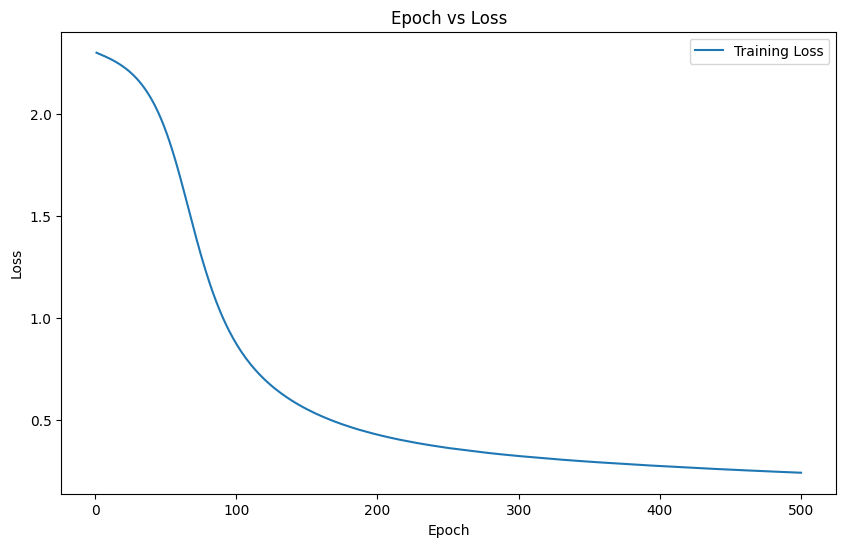


For model A, Validation set: Average loss: 0.2975, Accuracy: 912/1000 (91%)


For model A, Test set: Average loss: 0.3373, Accuracy: 1821/2000 (91%)



In [5]:
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch


class MNISTOneHot(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        data, target = self.mnist_dataset[idx]
        # ONe hot encoding
        target_one_hot = torch.zeros(10)
        target_one_hot[target] = 1
        return data, target_one_hot

#loading and converting mnist_dataset
transform = transforms.Compose([transforms.ToTensor(), ])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_dataset = Subset(mnist_dataset, range(8000))
mnist_one_hot = MNISTOneHot(mnist_dataset)

train_size = 5000
val_size = 1000
test_size = 2000
train_dataset, val_dataset, test_dataset = random_split(mnist_one_hot, [train_size, val_size, test_size])


# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss_values = []

    for i in range(1,epoch+1):
        epoch_loss=0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.size(0)
        epoch_loss /= len(train_loader.dataset)
        loss_values.append(epoch_loss)

    # Plots
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epoch + 1), loss_values, label='Training Loss')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def test(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.argmax(dim=1, keepdim=True)).sum().item()


    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, correct, len(val_loader.dataset), accuracy


#SGD
class CustomSGD:
    def __init__(self, parameters, lr=0.01):
        self.params = list(parameters)
        self.lr = lr

    def step(self):
        for p in self.params:
            if p.grad is not None:
                p.data -= self.lr * p.grad.data

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()


# network A
class NetworkA(nn.Module):
    def __init__(self):
        super(NetworkA, self).__init__()
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_a = NetworkA().to(device)

optimizer_a = CustomSGD(model_a.parameters(), lr=0.001)


# DataLoaders for train, validation, and test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

train(model_a, device, train_loader, optimizer_a, 500)

#for validation
val_loss, correct, x, accuracy = test(model_a, device, val_loader)
print('\nFor model A, Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, x, accuracy))

#for testing
test_loss, correct, x, accuracy  = test(model_a, device, test_loader)
print('\nFor model A, Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, x, accuracy))


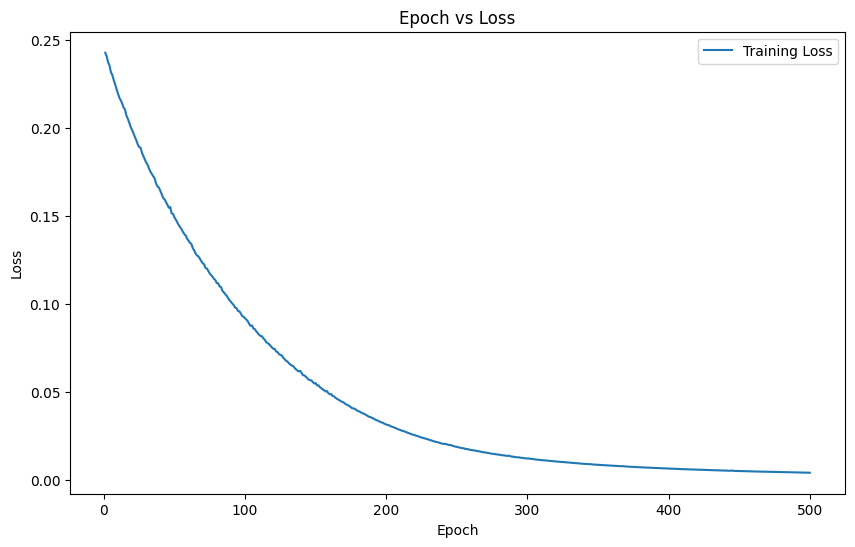


Validation set: Average loss: 0.2791, Accuracy: 936/1000 (94%)


Test set: Average loss: 0.3588, Accuracy: 1863/2000 (93%)



In [6]:
optimizer_a = CustomSGD(model_a.parameters(), lr=0.01)

train(model_a, device, train_loader, optimizer_a, 500)

val_loss, correct, x, accuracy = test(model_a, device, val_loader)
print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, x, accuracy))

#for testing
test_loss, correct, x, accuracy  = test(model_a, device, test_loader)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, x, accuracy))


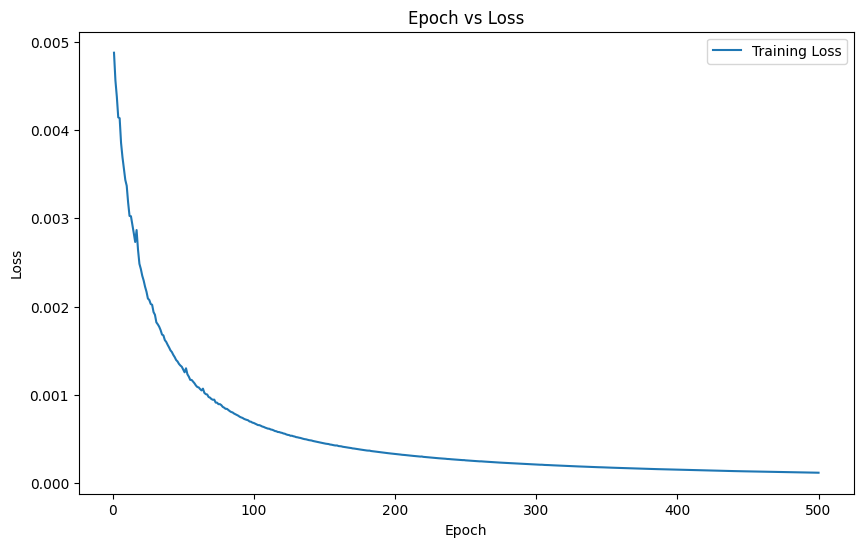


Validation set: Average loss: 0.3985, Accuracy: 936/1000 (94%)


Test set: Average loss: 0.5035, Accuracy: 1866/2000 (93%)



In [7]:
optimizer_a = CustomSGD(model_a.parameters(), lr=0.1)

train(model_a, device, train_loader, optimizer_a, 500)

val_loss, correct, x, accuracy = test(model_a, device, val_loader)
print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, x, accuracy))

#for testing
test_loss, correct, x, accuracy  = test(model_a, device, test_loader)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, x, accuracy))


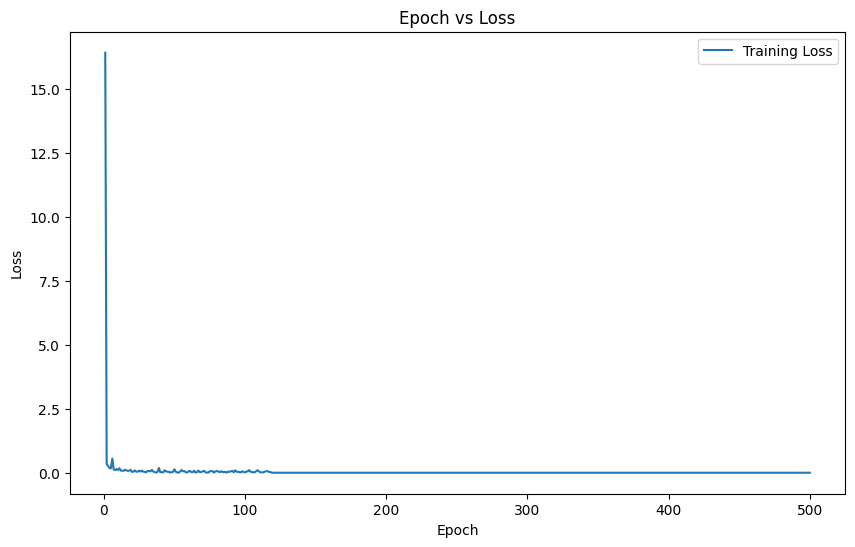


Validation set: Average loss: 2.1099, Accuracy: 950/1000 (95%)


Test set: Average loss: 3.3076, Accuracy: 1872/2000 (94%)



In [8]:
class CustomRMSprop:
    def __init__(self, parameters, lr=0.01, alpha=0.99, epsilon=1e-8):
        self.params = list(parameters)
        self.lr = lr
        self.alpha = alpha
        self.epsilon = epsilon
        self.squared_grads = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        for p, squared_grad in zip(self.params, self.squared_grads):
            if p.grad is not None:
                squared_grad.mul_(self.alpha).addcmul_(p.grad.data, p.grad.data, value=1 - self.alpha)
                p.data -= self.lr / (squared_grad.sqrt() + self.epsilon) * p.grad.data
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

optimizer_a = CustomRMSprop(model_a.parameters(), lr=0.01)

train(model_a, device, train_loader, optimizer_a, 500)

val_loss, correct, x, accuracy = test(model_a, device, val_loader)
print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, x, accuracy))

#for testing
test_loss, correct, x, accuracy  = test(model_a, device, test_loader)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, x, accuracy))

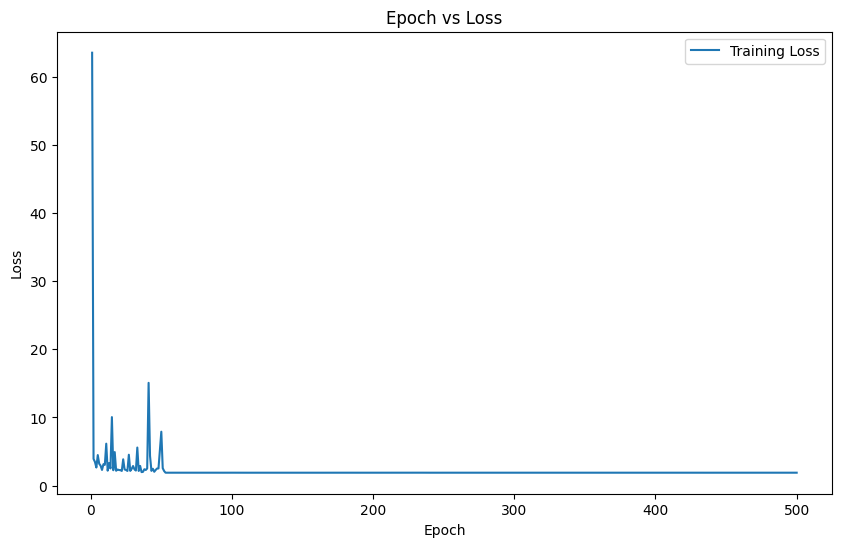


Validation set: Average loss: 1.9384, Accuracy: 253/1000 (25%)


Test set: Average loss: 1.9194, Accuracy: 494/2000 (25%)



In [9]:
class CustomRMSprop:
    def __init__(self, parameters, lr=0.1, alpha=0.9, epsilon=1e-8):
        self.params = list(parameters)
        self.lr = lr
        self.alpha = alpha
        self.epsilon = epsilon
        self.squared_grads = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        for p, squared_grad in zip(self.params, self.squared_grads):
            if p.grad is not None:
                squared_grad.mul_(self.alpha).addcmul_(p.grad.data, p.grad.data, value=1 - self.alpha)
                p.data -= self.lr / (squared_grad.sqrt() + self.epsilon) * p.grad.data
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

optimizer_a = CustomRMSprop(model_a.parameters(), lr=0.1)

train(model_a, device, train_loader, optimizer_a, 500)

val_loss, correct, x, accuracy = test(model_a, device, val_loader)
print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, x, accuracy))

#for testing
test_loss, correct, x, accuracy  = test(model_a, device, test_loader)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, x, accuracy))

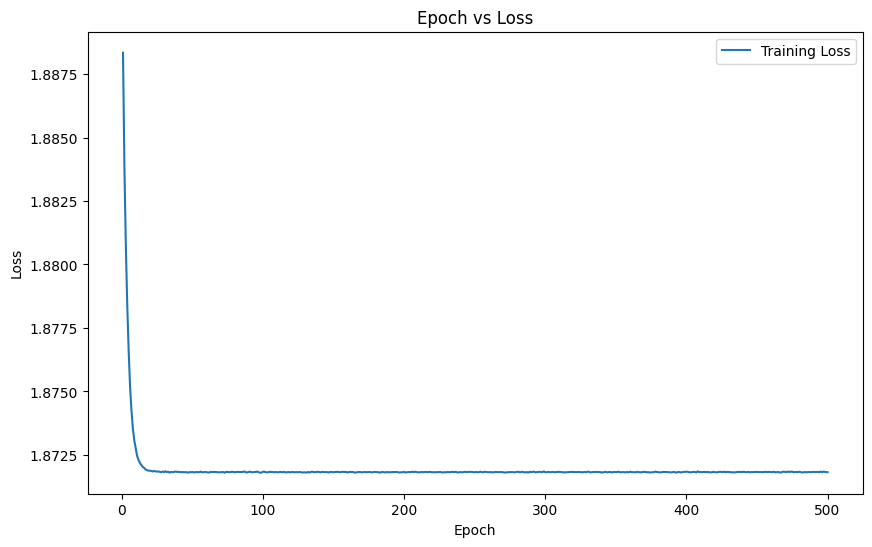


Validation set: Average loss: 1.9028, Accuracy: 253/1000 (25%)


Test set: Average loss: 1.8916, Accuracy: 494/2000 (25%)



In [10]:
class CustomRMSprop:
    def __init__(self, parameters, lr=0.001, alpha=0.9, epsilon=1e-8):
        self.params = list(parameters)
        self.lr = lr
        self.alpha = alpha
        self.epsilon = epsilon
        self.squared_grads = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        for p, squared_grad in zip(self.params, self.squared_grads):
            if p.grad is not None:
                squared_grad.mul_(self.alpha).addcmul_(p.grad.data, p.grad.data, value=1 - self.alpha)
                p.data -= self.lr / (squared_grad.sqrt() + self.epsilon) * p.grad.data
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

optimizer_a = CustomRMSprop(model_a.parameters(), lr=0.001)

train(model_a, device, train_loader, optimizer_a, 500)

val_loss, correct, x, accuracy = test(model_a, device, val_loader)
print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, x, accuracy))

#for testing
test_loss, correct, x, accuracy  = test(model_a, device, test_loader)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, x, accuracy))